## Zaimportowanie potrzebnych bibliotek oraz plików z kodem źródłowym

In [1]:
!git clone https://github.com/mateusztobiasz/zum.git
%cd zum
!pip install -r requirements.txt

In [2]:
from dataset import Dataset
from utils import split_data, plot_metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from strategies import *
from train import ActiveLearner, FullLearner
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.base import clone
import numpy as np
from utils import evaluate_model, plot_strategy_comparison

## Konfiguracja hiperparametrów
Słownik `CONFIG` definiuje podstawowe parametry dla eksperymentów z uczeniem aktywnym:

- **`initial_size`**: Ułamek danych (np. `0.01` = 1%) używany jako początkowy zbiór treningowy.
- **`n_queries`**: Liczba iteracji zapytań, czyli ile razy model może dobrać dodatkowe próbki z puli.
- **`query_size`**: Liczba przykładów wybieranych w każdej iteracji zapytania.
- **`test_size`**: Ułamek danych przeznaczonych na zbiór testowy (np. `0.2` = 20%).

In [ ]:
CONFIG = {
    "initial_size": 0.01,
    "n_queries": 200,
    "query_size": 10,
    "test_size": 0.2,
}

## Wczytanie zbioru danych i podział
- Inicjalizacja i załadowanie wybranego zbioru danych (`"yeast"`), który jest wieloklasowym zbiorem danych o lokalizacji białek.
- Pobranie cech (`X`) i etykiet (`y`) ze zbioru.
- Podział danych na:
  - `X_init`, `y_init`: początkowy mały zbiór treningowy (określony przez `initial_size`),
  - `X_pool`, `y_pool`: pula próbek do aktywnego dobierania kolejnych danych,
  - `X_test`, `y_test`: zbiór testowy (określony przez `test_size`),
  - `X_full`, `y_full`: cały zestaw danych do pełnego treningu (np. do wyliczenia baseline).

In [ ]:
CONFIG = {
    "initial_size": 0.01,
    "n_queries": 200,
    "query_size": 10,
    "test_size": 0.2,
}

dataset = Dataset("yeast")
X, y = dataset.get()

X_init, y_init, X_pool, y_pool, X_test, y_test, X_full, y_full = split_data(X, y, CONFIG["initial_size"], CONFIG["test_size"])

NameError: name 'Dataset' is not defined

## Przygotowanie modeli oraz strategii

- `models_map`: Słownik zawierający klasyfikatory używane w eksperymencie:
  - **Logistic Regression** — regresja logistyczna z maksymalnie 1000 iteracjami,
  - **Random Forest** — las losowy z 100 drzewami,
  - **SVC** — maszyna wektorów nośnych z jądrem RBF i włączonym probabilistycznym przewidywaniem,
  - **MLP** — wielowarstwowy perceptron z jedną warstwą ukrytą o 100 neuronach.

- `strategies_map`: Słownik strategii aktywnego uczenia:
  - **random** — losowy dobór próbek,
  - **least_confidence** — wybór próbek o najniższej maksymalnej pewności predykcji,
  - **margin** — dobór próbek o najmniejszej różnicy między dwiema najwyższymi predykcjami,
  - **entropy** — dobór próbek o największej entropii rozkładu predykcji (niepewności).

In [5]:
models_map = {
    "logistic_regression": LogisticRegression(max_iter=1000, random_state=42),
    "random_forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "svc": SVC(probability=True, kernel='rbf', random_state=42),
    "mlp": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42),
}

strategies_map = {
    "random": RandomSampling(),
    "least_confidence": LeastConfidence(),
    "margin": MarginSampling(),
    "entropy": EntropySampling(),
}

## Aktywne uczenie się za pomocą klasy ActiveLearner

Aktywne uczenie się (Active Learning) to podejście, w którym model iteracyjnie wybiera najbardziej wartościowe próbki do oznaczenia i trenowania, aby maksymalnie zwiększyć swoją efektywność przy ograniczonej liczbie oznaczonych danych. Klasa `ActiveLearner` implementuje taki proces, korzystając z różnych strategii wyboru próbek (np. losowe, najmniejsza pewność, margin sampling, entropia).

W naszych eksperymentach zaczynamy od zbioru **Yeast**, który jest klasycznym, wieloklasowym zbiorem danych biologicznych z 10 klasami. Dzięki temu możemy ocenić działanie strategii aktywnego uczenia w rzeczywistym problemie klasyfikacji wieloklasowej.

Następnie testujemy metody na zbiorze **Optdigits**, który zawiera obrazy ręcznie pisanych cyfr. Ten zbiór również jest wieloklasowy i pozwala sprawdzić skuteczność aktywnego uczenia na danych obrazowych z wyraźnie rozgraniczonymi klasami.

In [6]:
from sklearn.base import clone

def run_experiments(models_map, strategies_map, X_full, y_full, X_init, y_init, X_pool, y_pool, X_test, y_test, config):
    results_all = []

    for model_name, model in models_map.items():
        full_learner = FullLearner(clone(model))
        baseline_metrics = full_learner.train(
            X_full, y_full, X_test, y_test
        )

        for strategy_name, strategy in strategies_map.items():
            print(f"Training with model: {model_name}, strategy: {strategy_name}")
            active_learner = ActiveLearner(clone(model), strategy)

            results = active_learner.train(
                X_init.copy(), 
                y_init.copy(),
                X_pool.copy(),
                y_pool.copy(),
                X_test,
                y_test,
                config["n_queries"],
                config["query_size"]
            )

            results_all.append({
                "model": model_name,
                "strategy": strategy_name,
                "results": results,
                "baseline": baseline_metrics 
            })

    return results_all


In [ ]:
results_all = run_experiments(
    models_map,
    strategies_map,
    X_full, y_full,
    X_init, y_init,
    X_pool, y_pool,
    X_test, y_test,
    CONFIG
)

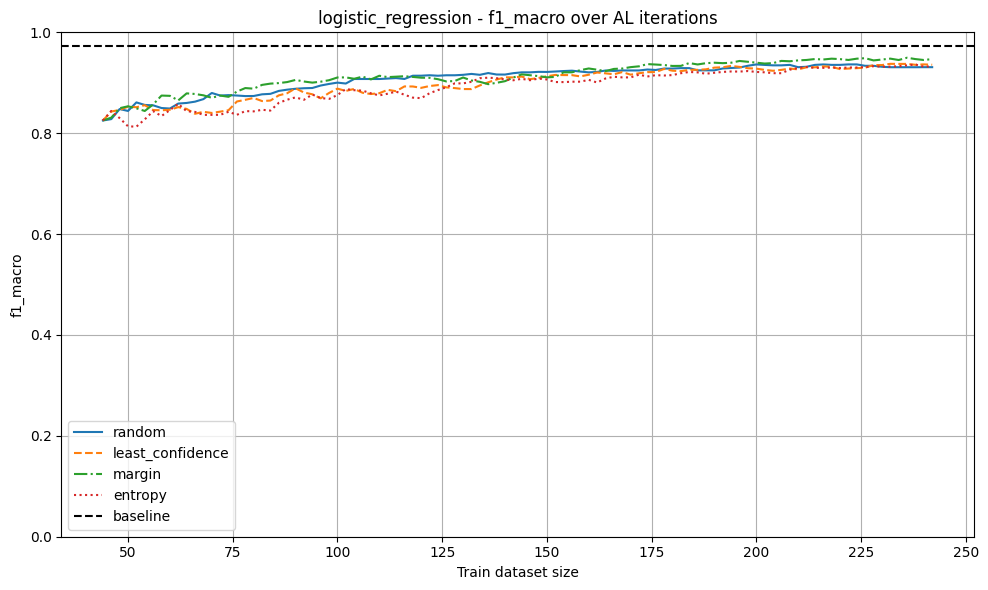

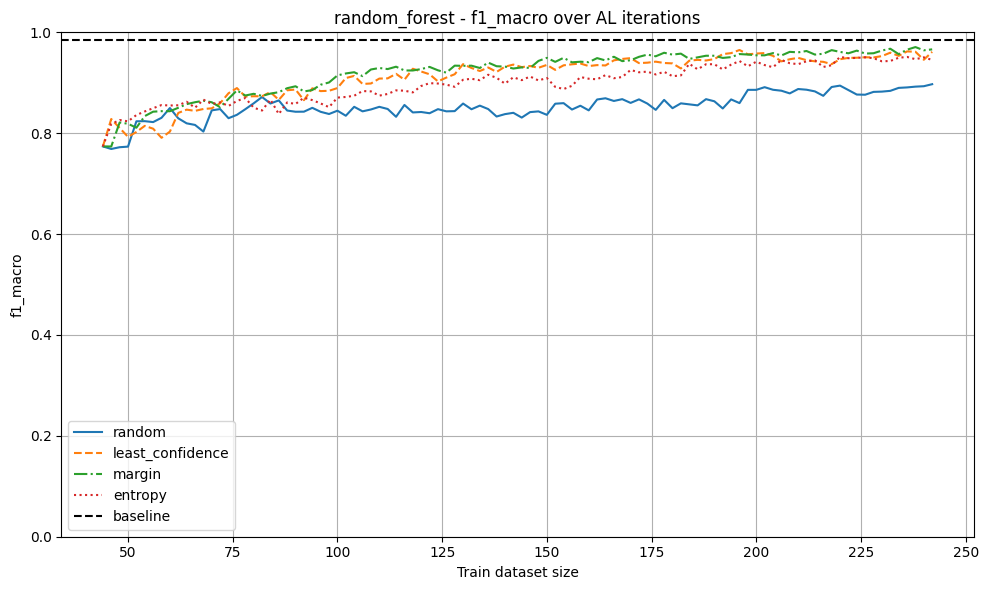

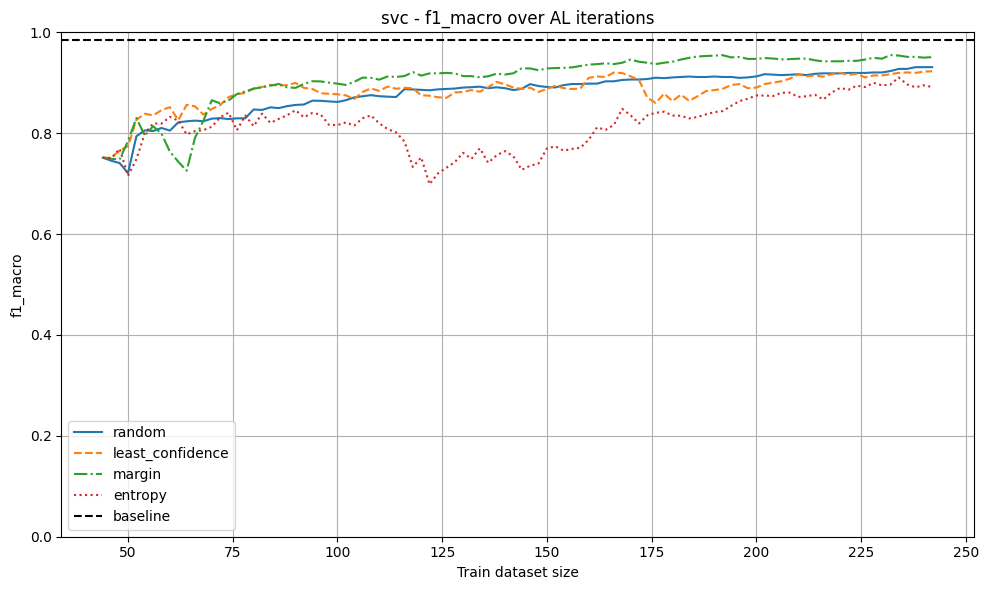

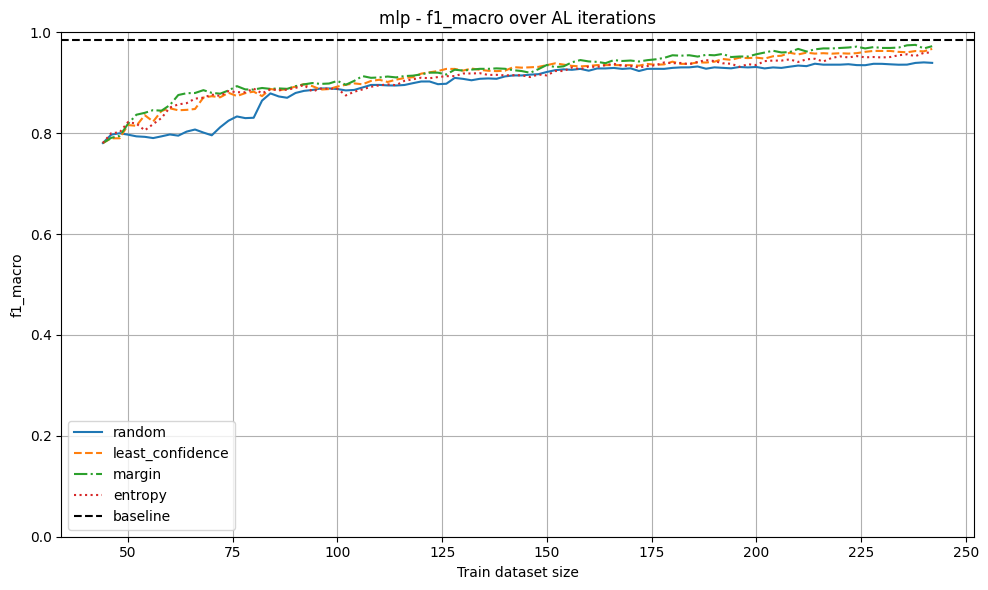

In [18]:
plot_strategy_comparison(results_all, "f1_macro")

Ładujemy dataset **Optdigits** (z bazy OpenML) – jest to zbiór danych wieloklasowych do rozpoznawania cyfr odręcznych.
- Konfigurujemy parametry aktywnego uczenia:
  - `initial_size`: 1% danych treningowych jako początkowy zbiór treningowy,
  - `n_queries`: 100 zapytań do modelu,
  - `query_size`: po 2 próbki wybierane w każdej iteracji aktywnego uczenia,
  - `test_size`: 20% danych zostaje odłożone na test.
- Dzielimy dane na: początkowy zbiór treningowy, pulę danych do aktywnego uczenia, zbiór testowy oraz pełny zbiór treningowy.
- Uruchamiamy eksperymenty dla zestawu modeli i strategii aktywnego uczenia.
- Wizualizujemy wyniki (metryka `f1_macro`) w zależności od rozmiaru zbioru treningowego po kolejnych iteracjach aktywnego uczenia.

Training with model: logistic_regression, strategy: random


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.38it/s]


Training with model: logistic_regression, strategy: least_confidence


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.38it/s]


Training with model: logistic_regression, strategy: margin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.94it/s]


Training with model: logistic_regression, strategy: entropy


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.01it/s]


Training with model: random_forest, strategy: random


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.10it/s]


Training with model: random_forest, strategy: least_confidence


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.86it/s]


Training with model: random_forest, strategy: margin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.88it/s]


Training with model: random_forest, strategy: entropy


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.79it/s]


Training with model: svc, strategy: random


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.14it/s]


Training with model: svc, strategy: least_confidence


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.05it/s]


Training with model: svc, strategy: margin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.85it/s]


Training with model: svc, strategy: entropy


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.27it/s]


Training with model: mlp, strategy: random


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.59it/s]


Training with model: mlp, strategy: least_confidence


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.30it/s]


Training with model: mlp, strategy: margin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.47it/s]


Training with model: mlp, strategy: entropy


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.38it/s]


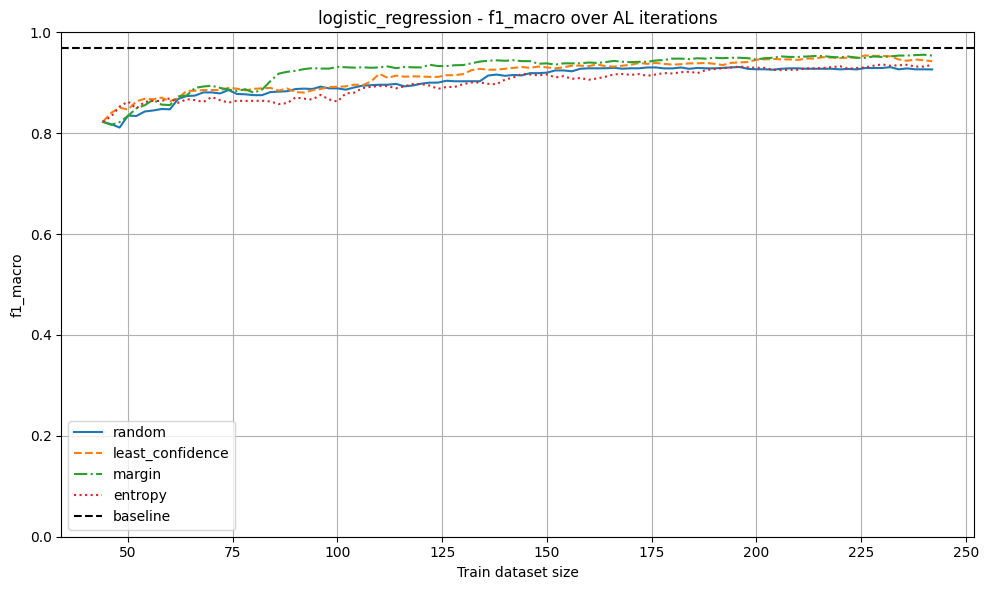

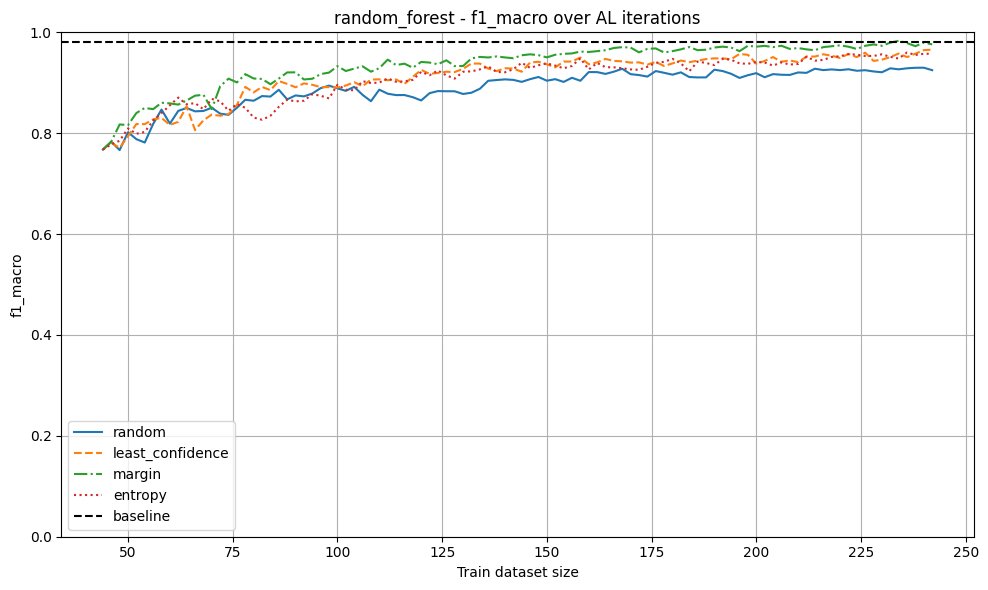

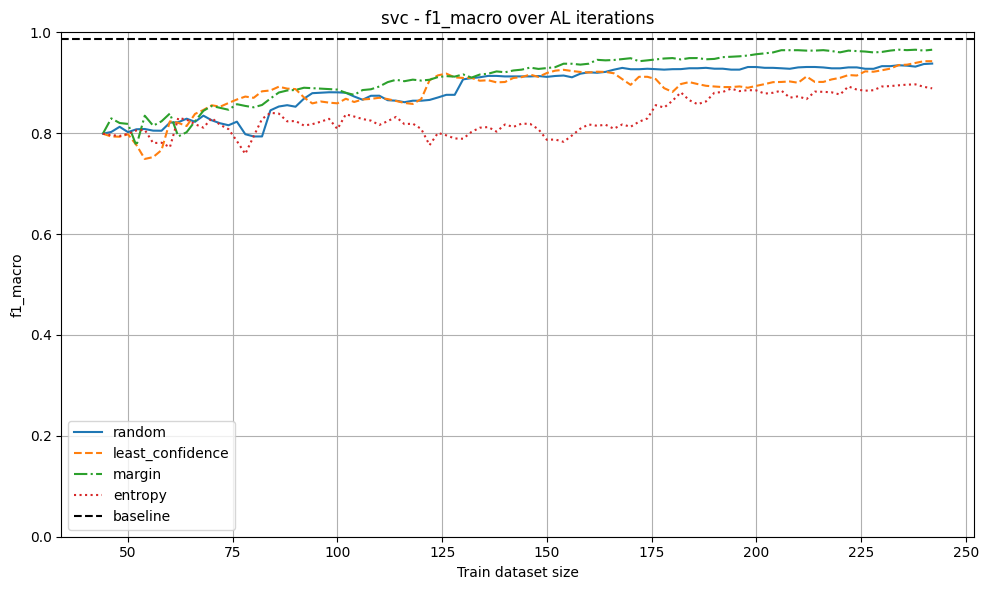

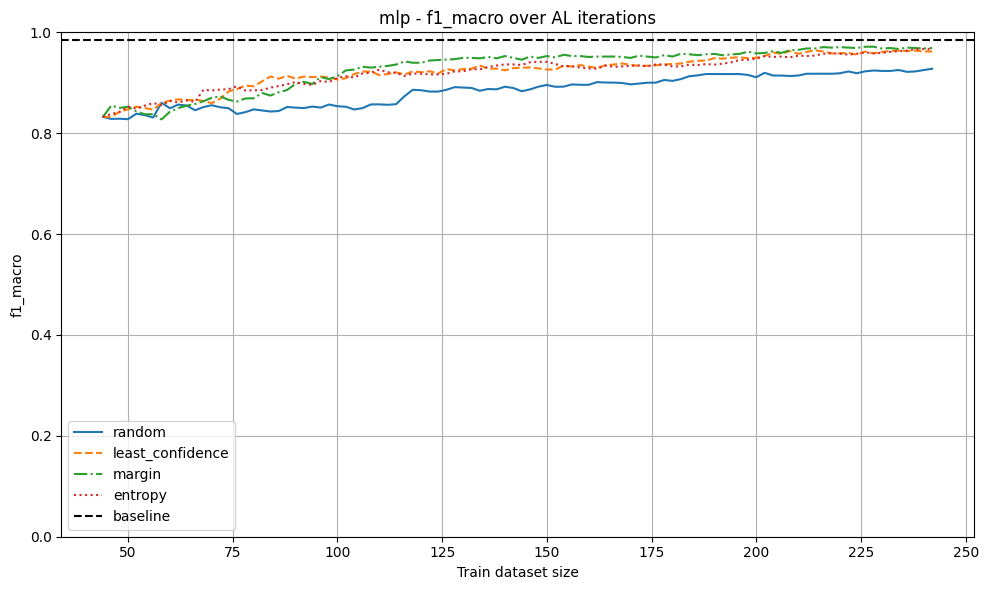

In [19]:
dataset = Dataset("optdigits")
X, y = dataset.get()

CONFIG = {
    "initial_size": 0.01,
    "n_queries": 100,
    "query_size": 2,
    "test_size": 0.2,
}

X_init, y_init, X_pool, y_pool, X_test, y_test, X_full, y_full = split_data(X, y, CONFIG["initial_size"], CONFIG["test_size"])

results_all = run_experiments(
    models_map,
    strategies_map,
    X_full, y_full,
    X_init, y_init,
    X_pool, y_pool,
    X_test, y_test,
    CONFIG
)
plot_strategy_comparison(results_all, "f1_macro")

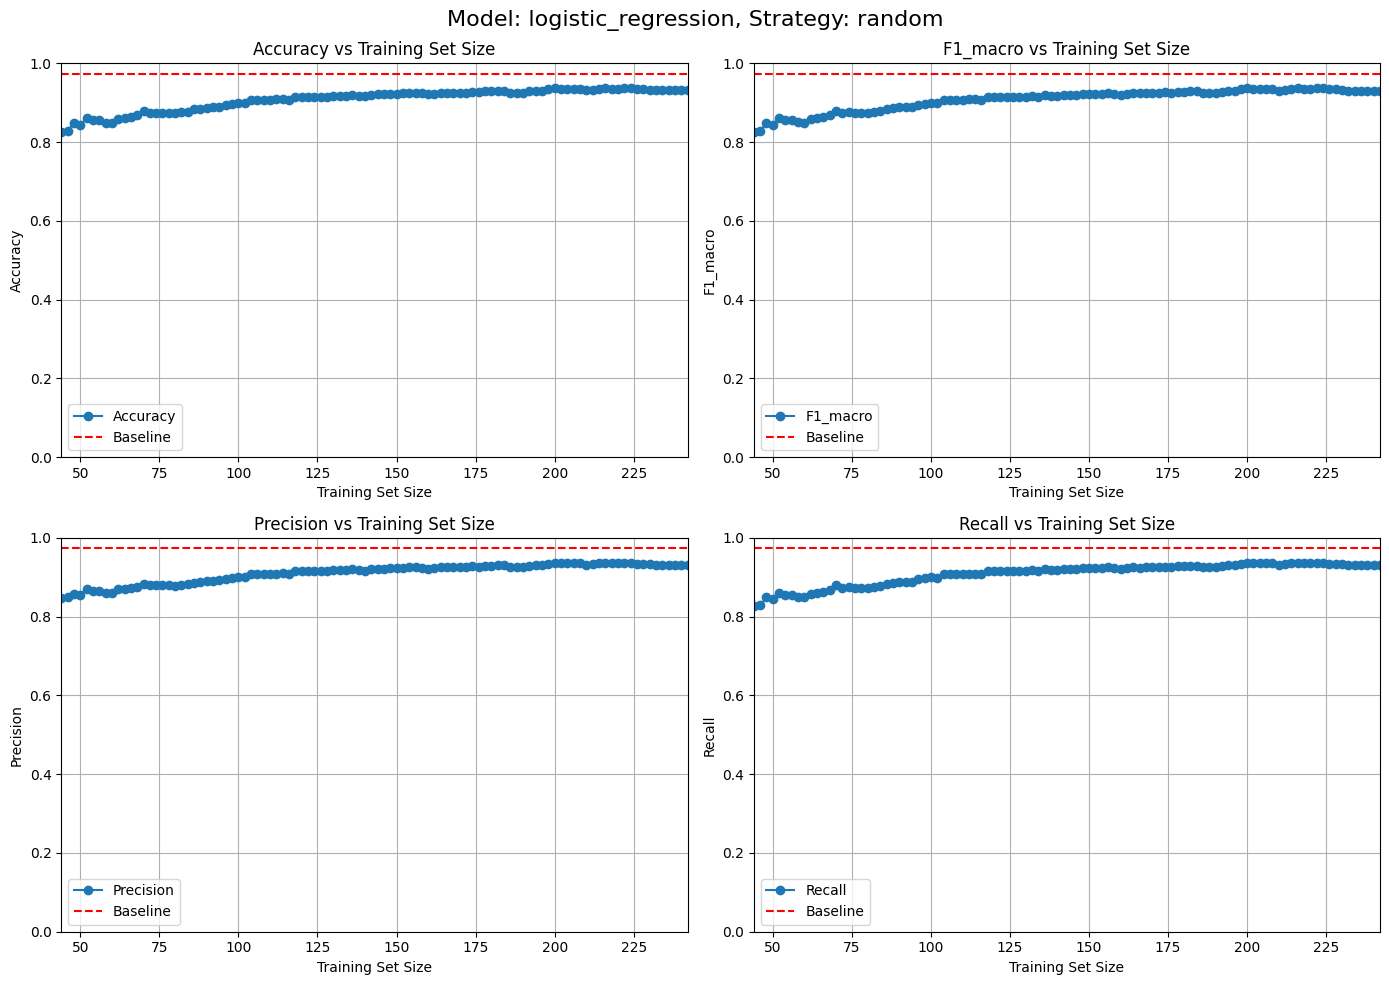

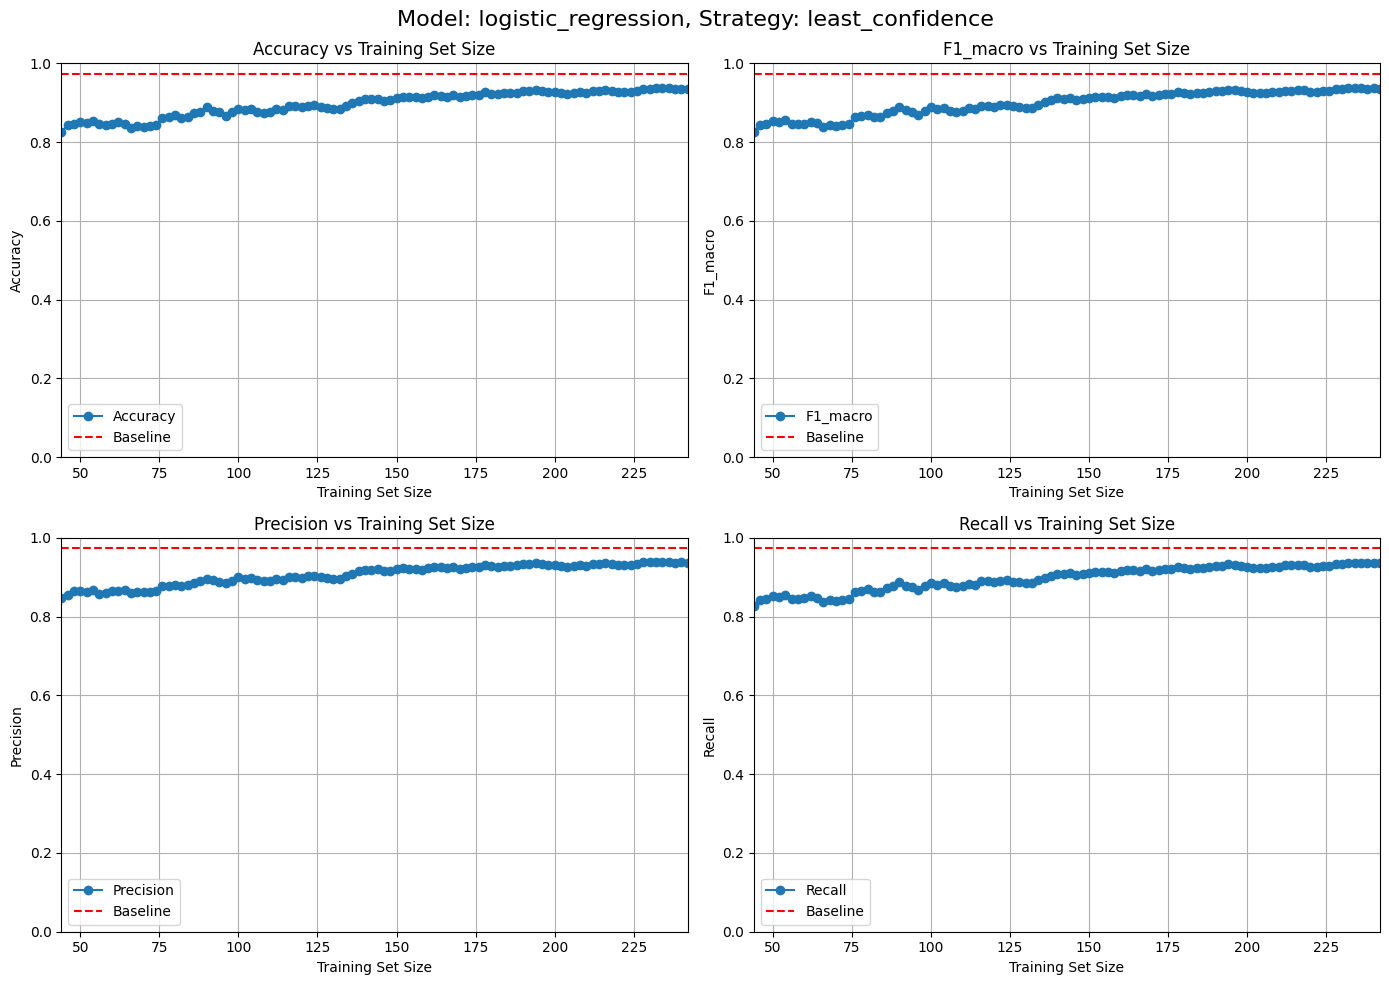

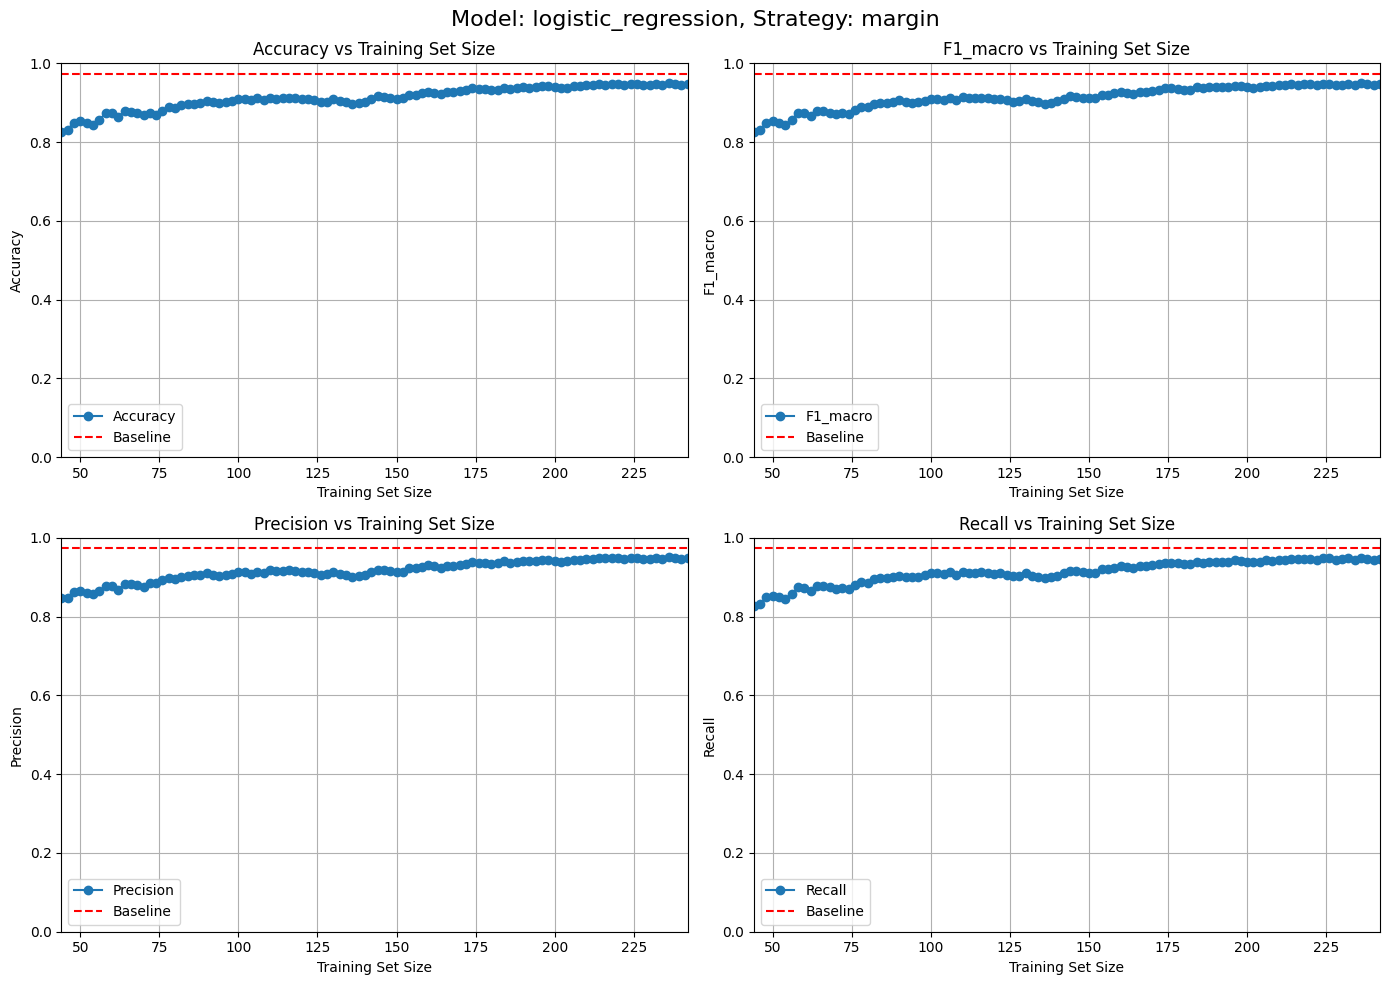

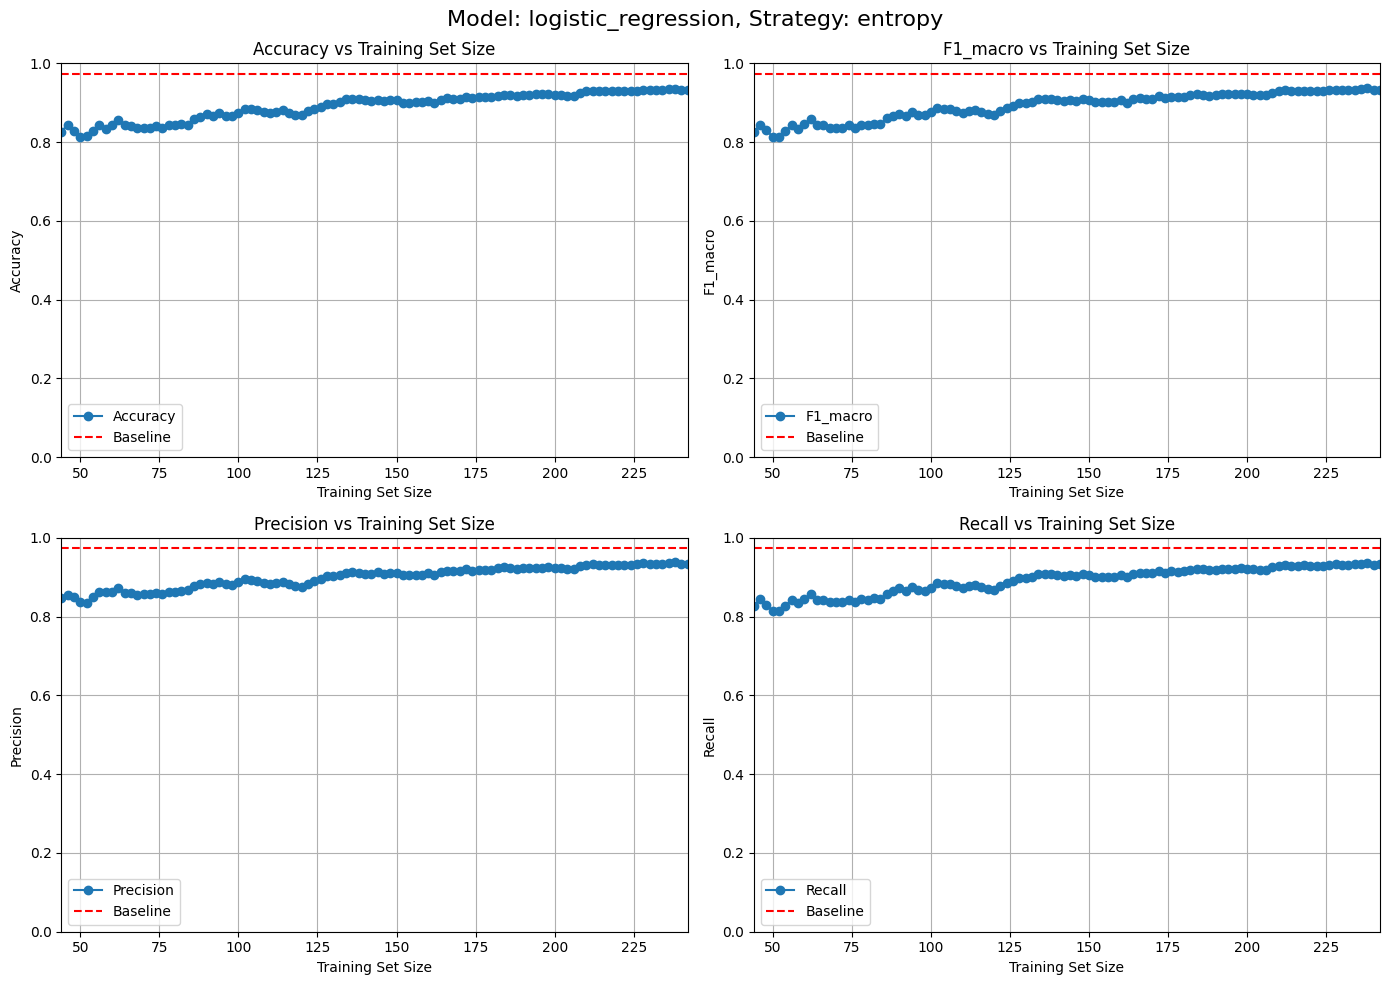

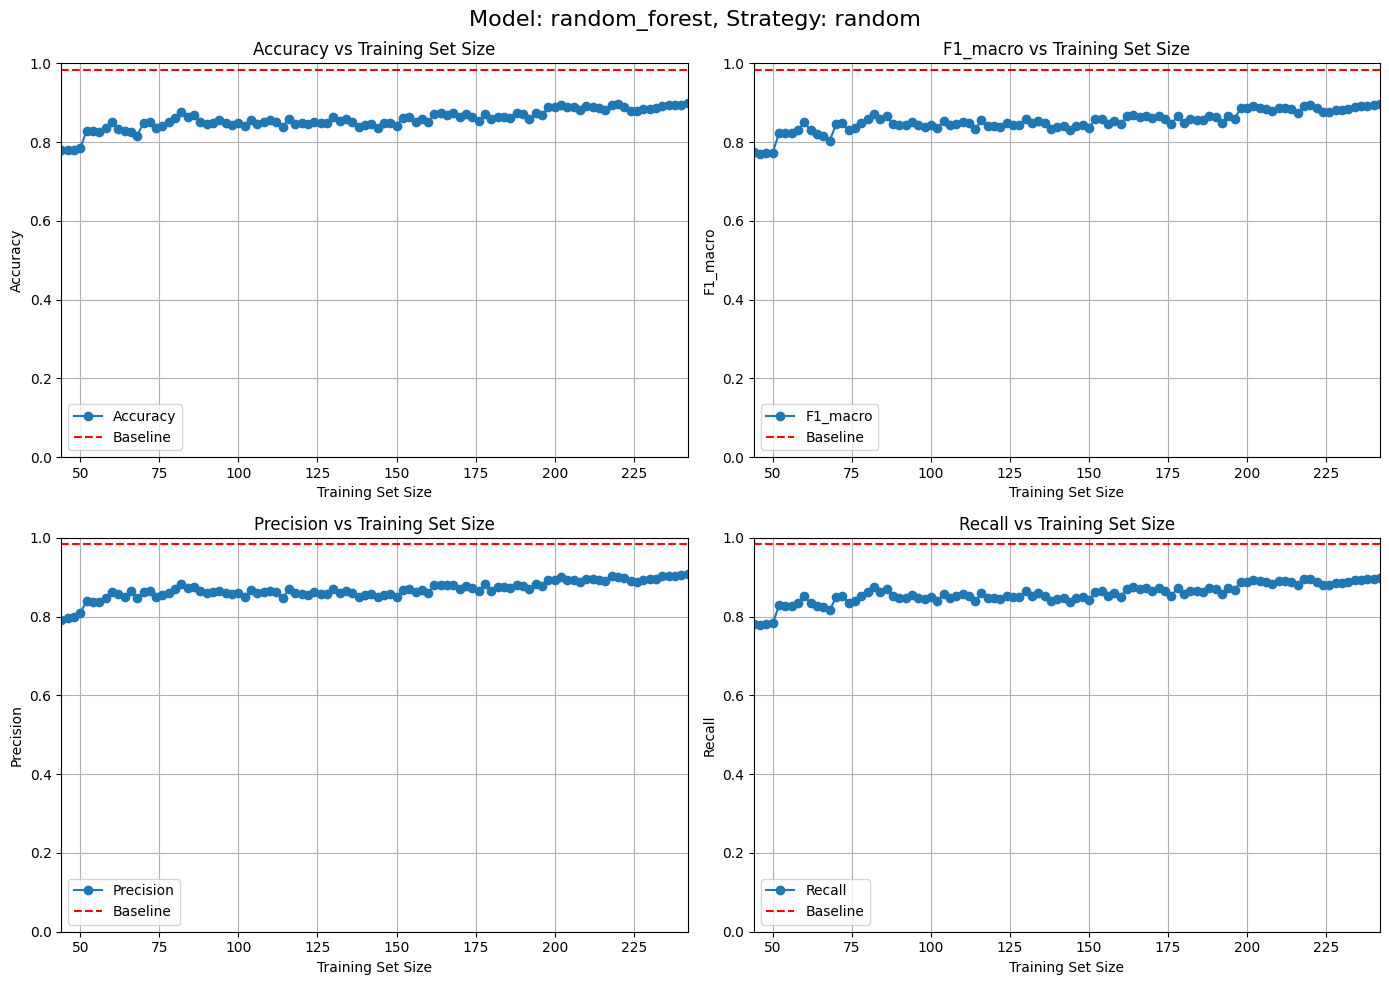

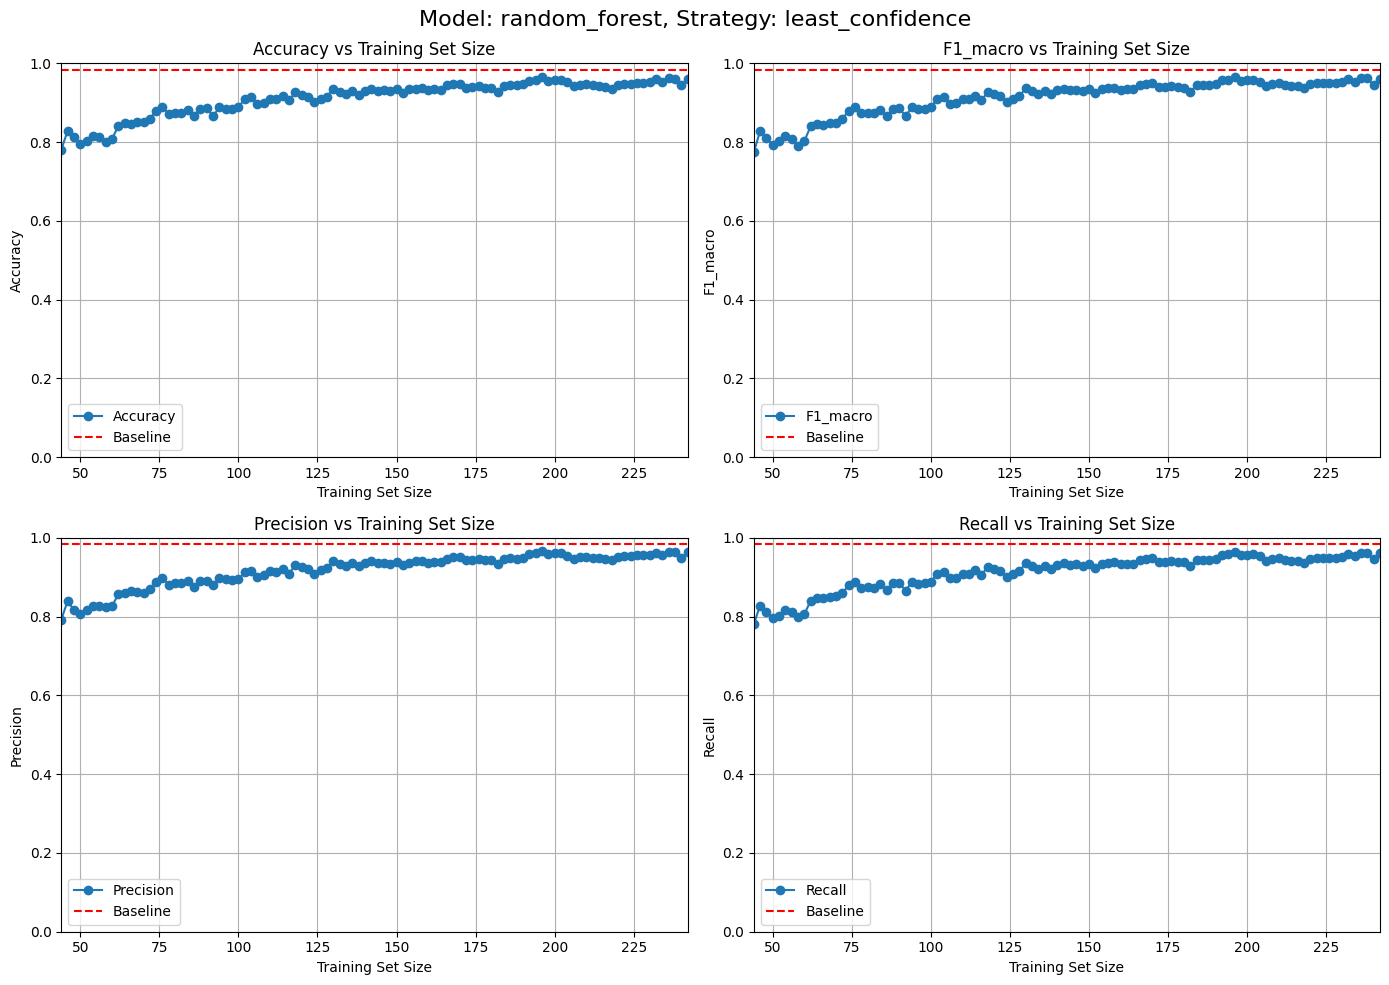

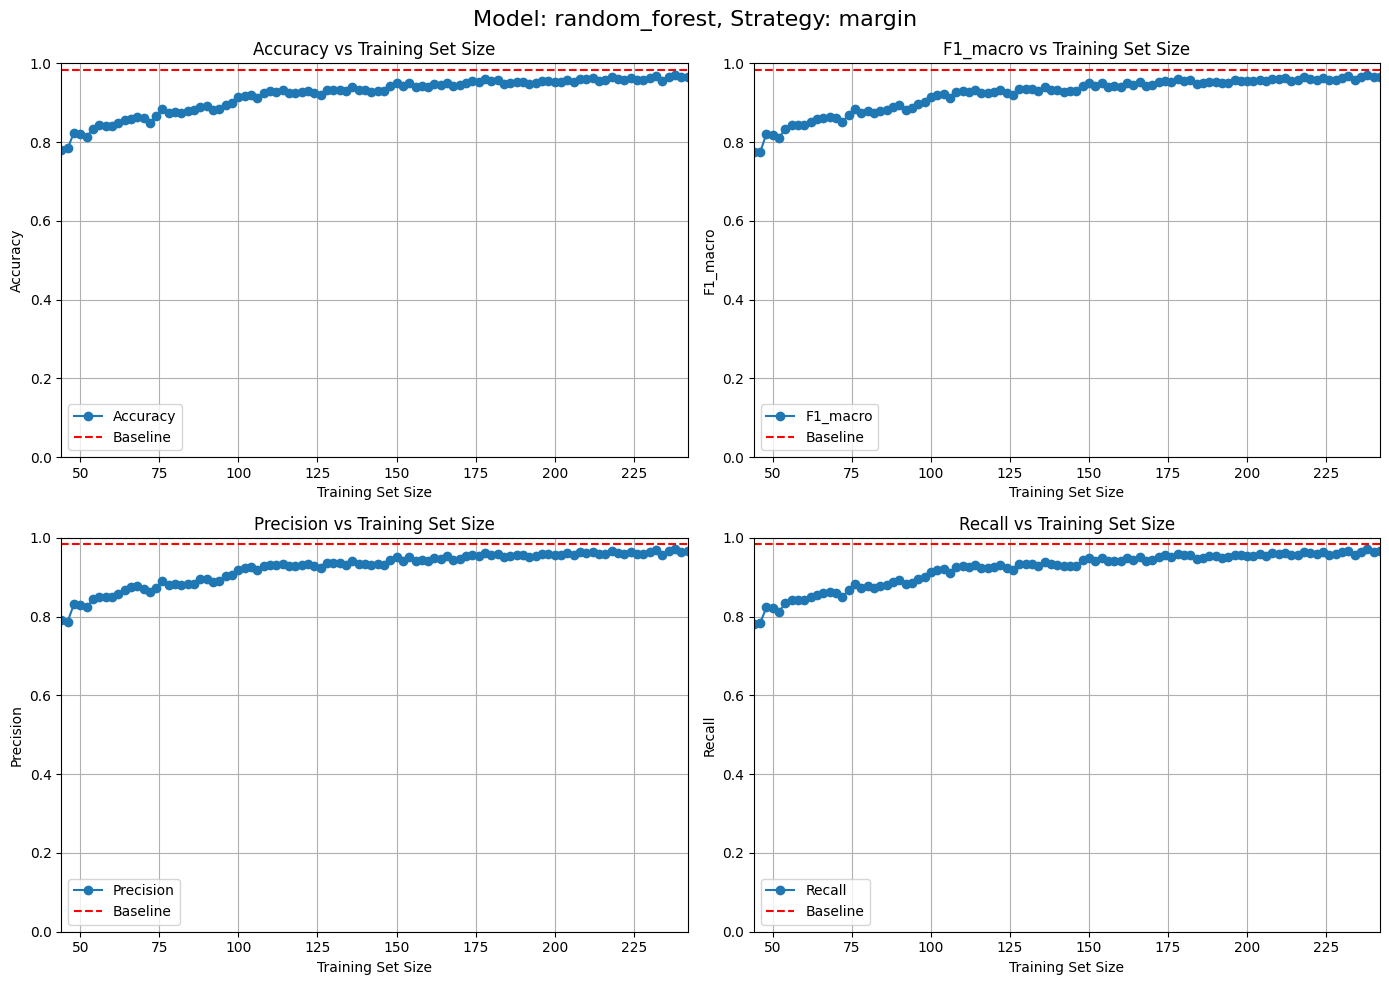

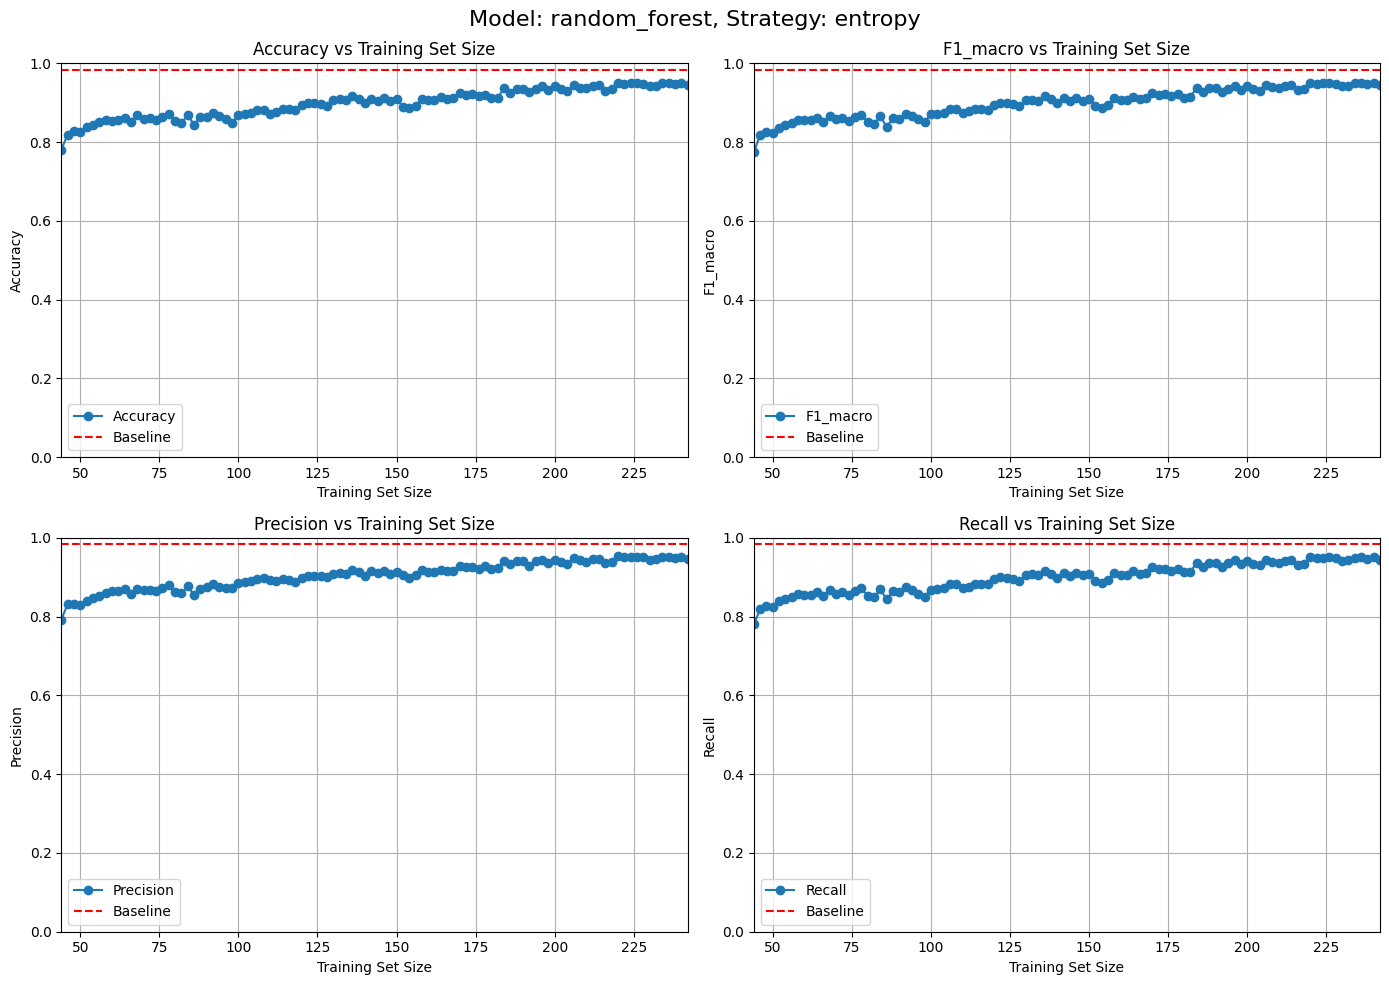

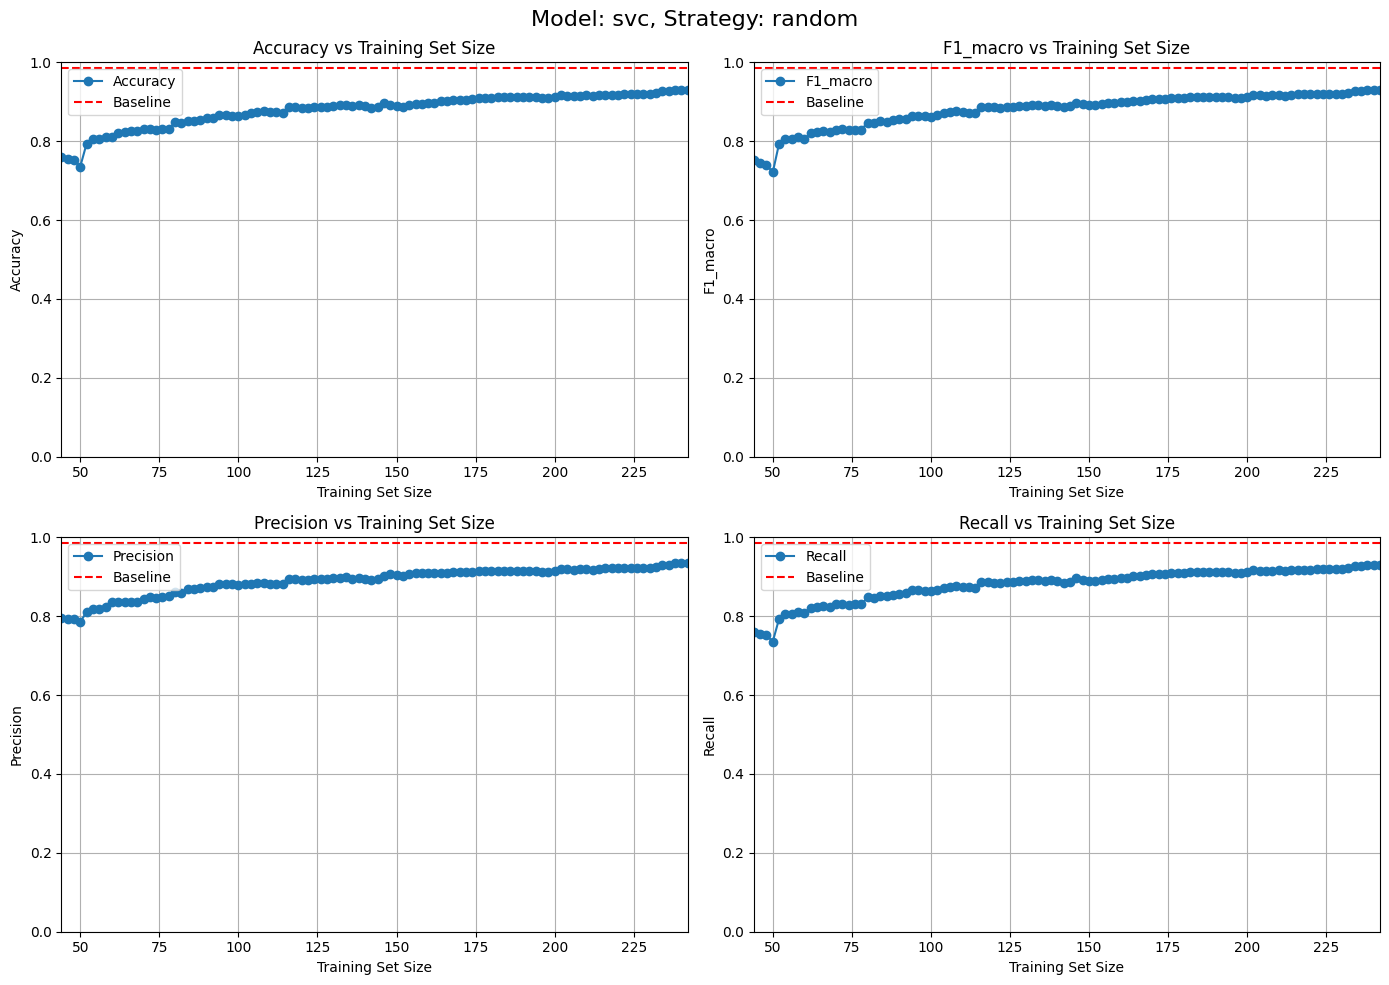

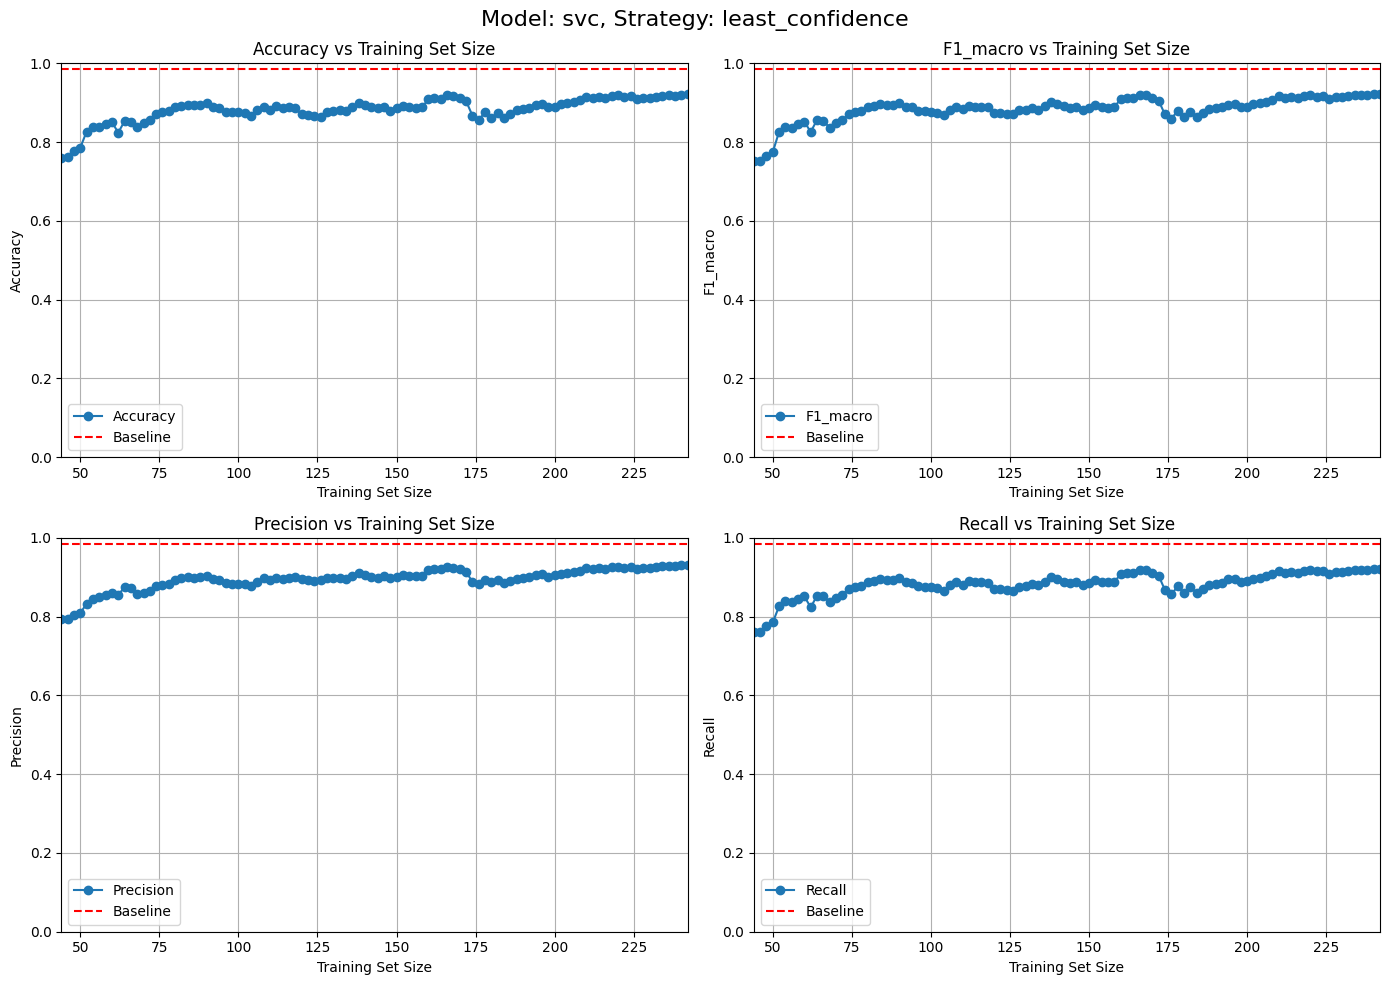

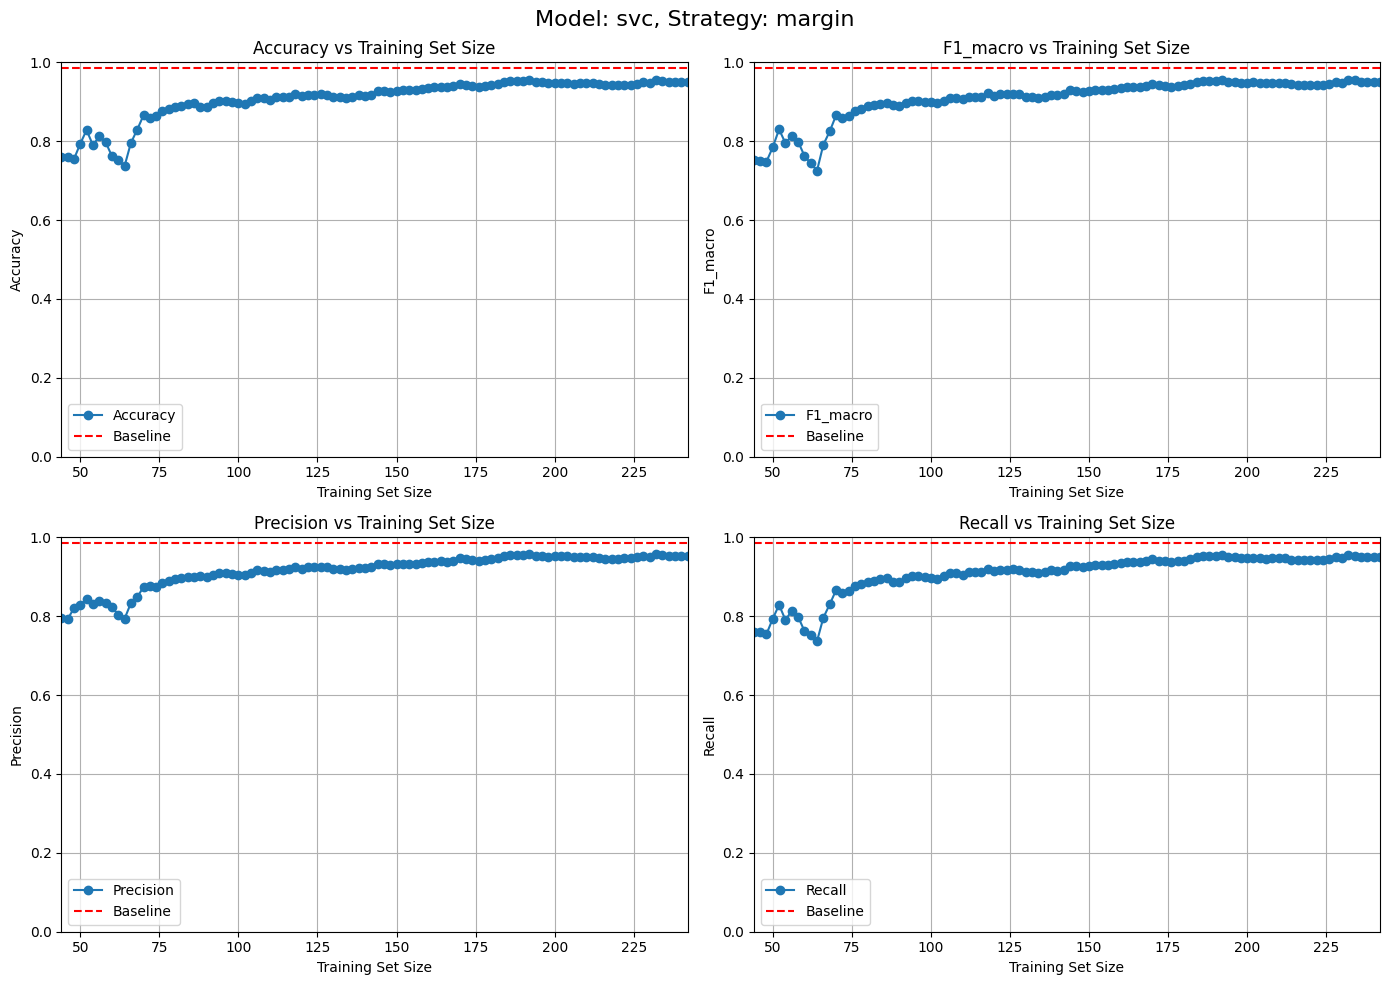

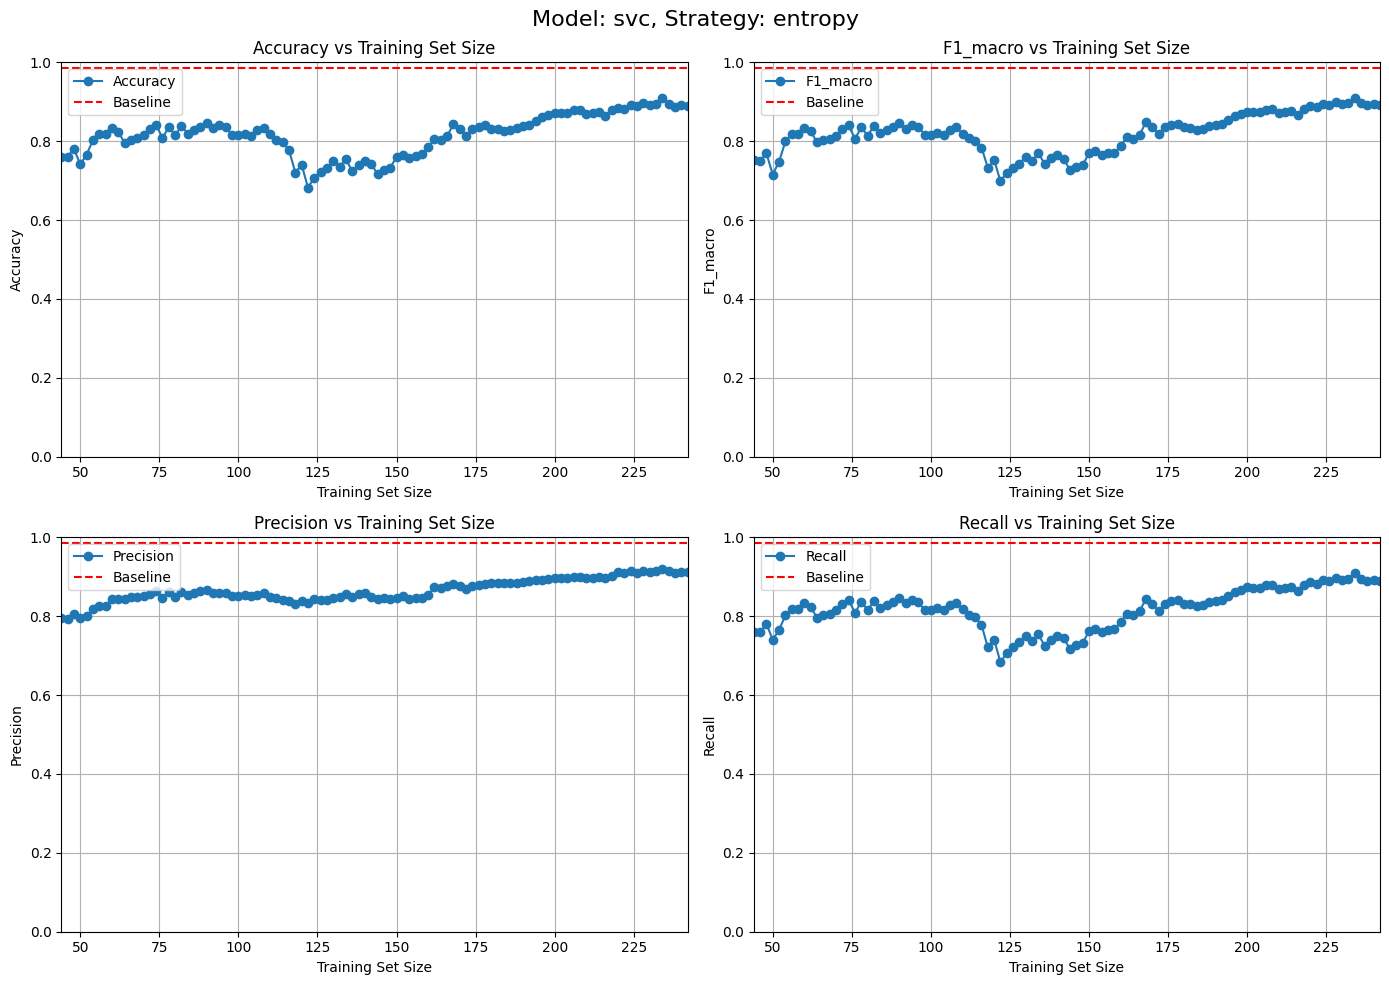

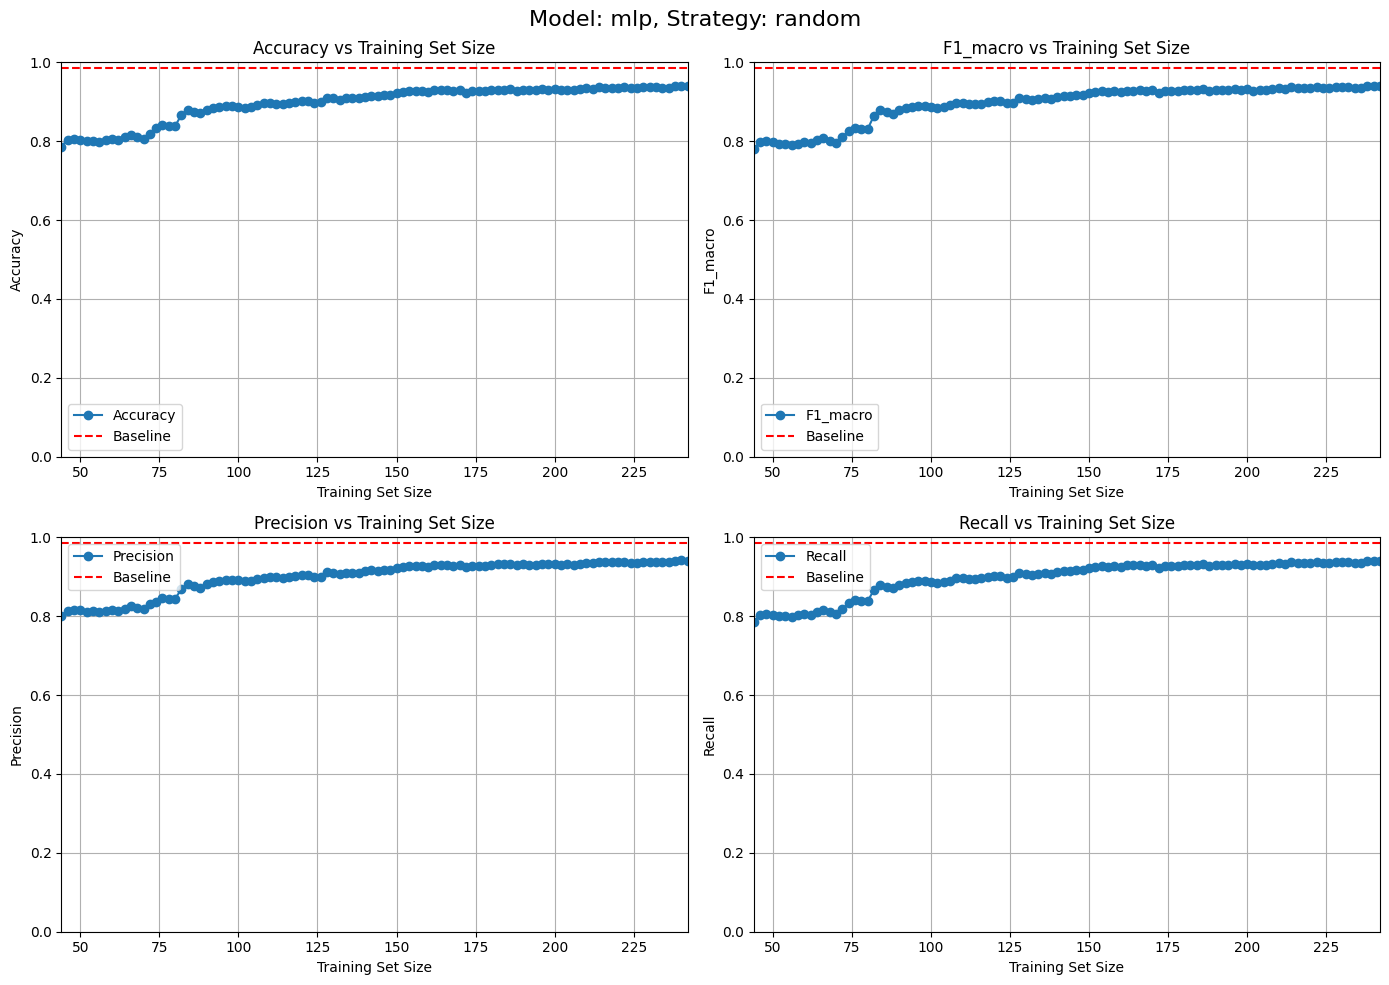

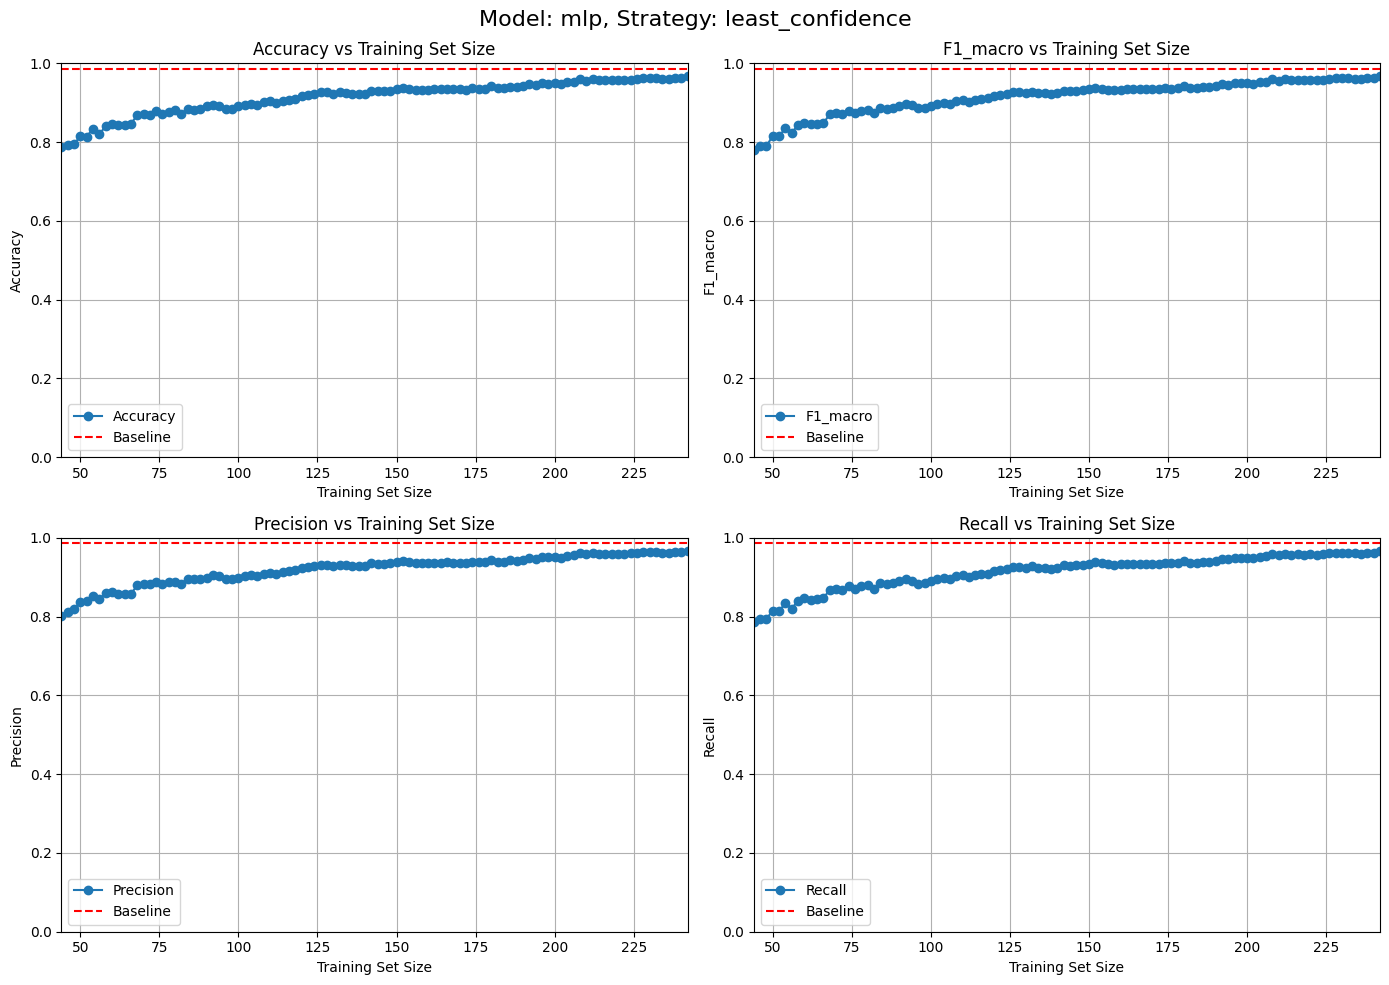

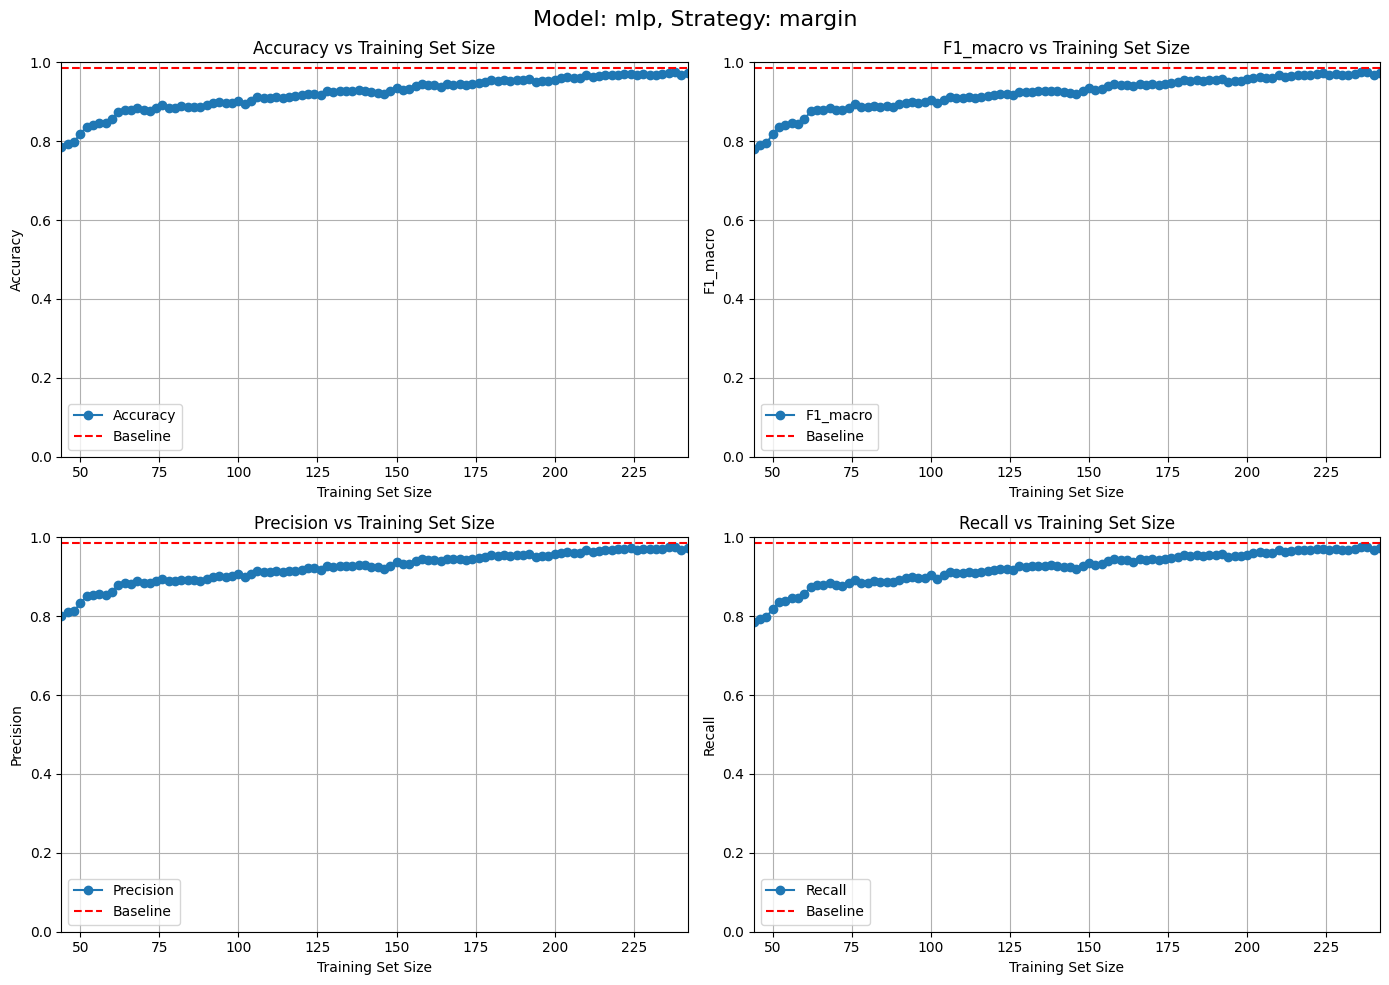

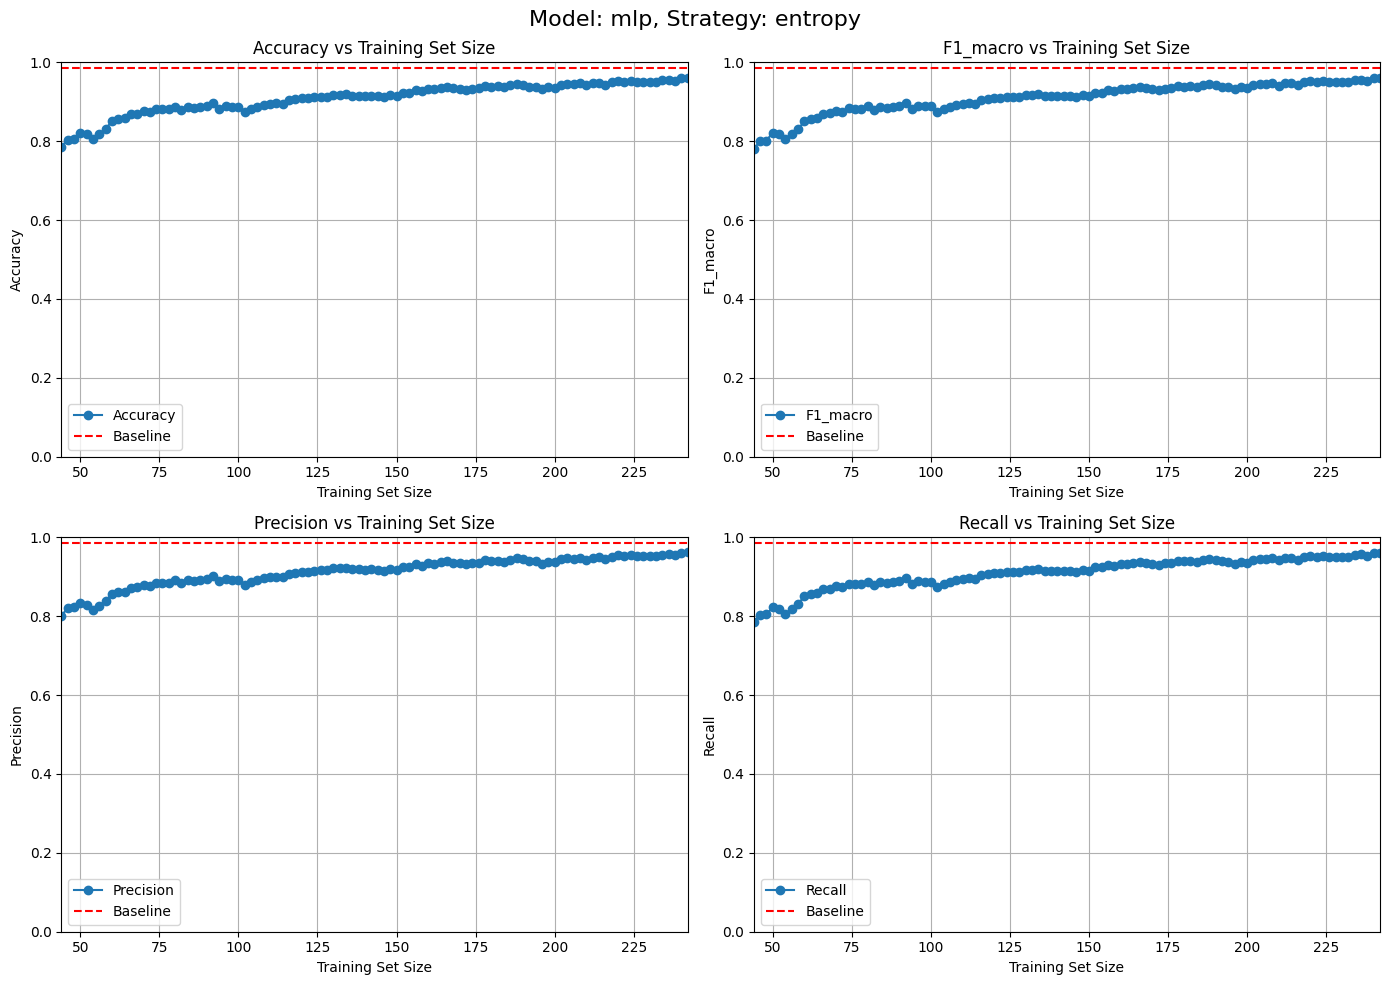

In [10]:
for run in results_all:
    model_name = run["model"]
    strategy_name = run["strategy"]
    metrics = run["results"]
    baseline_metrics = run["baseline"]
        
    plot_metrics(model_name, strategy_name, metrics, baseline_metrics)
